In [1]:
import pandas as pd
import json
import numpy as np
from collections import OrderedDict
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling.random_over_sampler import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn

seaborn.set_style("dark")

%matplotlib inline

In [2]:
yearly_prs = []
insolvency_data = []
for line in open("./data/evolving_pagerank_large_graph_yearly_experiment.jsonline"):
    record = json.loads(line)
    yearly_prs += [dict(record["pr"])]
    insolvency_data += [{"id": record["id"], "stringId": record["stringId"], "nodeType": record["nodeType"]}]
yearly_prs_df = pd.DataFrame(yearly_prs)
insolvency_data_df = pd.DataFrame(insolvency_data)
assert yearly_prs_df.shape[0] == insolvency_data_df.shape[0]

In [3]:
yearly_prs_df = yearly_prs_df.drop([2008, 2009, 2010], axis=1)

## Preprocessing

In [4]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [5]:
WINDOW_SIZE = 4
dataset_df = pd.DataFrame()
dataset_insdata_df = pd.DataFrame()
for window in rolling_window(yearly_prs_df.columns, WINDOW_SIZE):
    features = yearly_prs_df[window[:WINDOW_SIZE - 1]]
    features.columns = np.array(
        map(lambda idx: "year_{}".format(idx), reversed(range(1, len(window[:-1]) + 1)))
    )
    
    pred = yearly_prs_df[[window[-1]]]
    pred.columns = np.array(["year_0"])
    dataset_df = dataset_df.append(pd.concat([features, pred], axis=1))
    dataset_insdata_df = dataset_insdata_df.append(insolvency_data_df)
    
assert dataset_insdata_df.shape[0] == dataset_df.shape[0]

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [7]:
X = dataset_df.drop("year_0", axis=1)
y = dataset_df[["year_0"]]

Text(0.5,1,'Histogram of raw values')

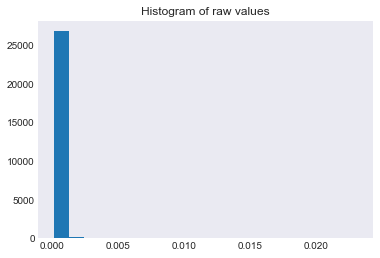

In [8]:
_ = plt.hist(y.values, 20)
plt.title("Histogram of raw values")

In [9]:
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

Text(0.5,1,'Histogram of values after 0-1 rescaling')

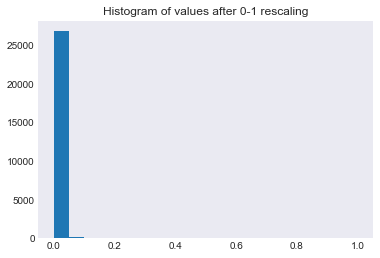

In [10]:
_ = plt.hist(y, 20)
plt.title("Histogram of values after 0-1 rescaling")

In [11]:
apply_sigmoid_func = np.vectorize(lambda x: 1 / (1 + np.exp(-4 * x)))

X = apply_sigmoid_func(X)
y = apply_sigmoid_func(y)

Text(0.5,1,'Histogram of values after applying the sigmoid function')

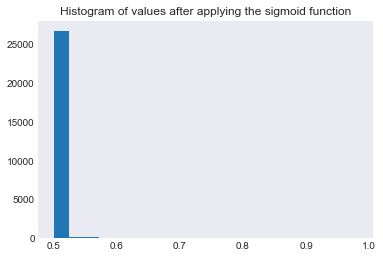

In [12]:
_ = plt.hist(y, 20)
plt.title("Histogram of values after applying the sigmoid function")

In [13]:
y = y.ravel()
ros = RandomOverSampler()
y_disc = np.digitize(y, np.arange(0, 1, 0.05))

Xy = np.column_stack((X, y))
Xy_resampled, y_resampled = ros.fit_sample(Xy, y_disc)

X = Xy_resampled[:,0:3]
y = Xy_resampled[:,3:4].T[0]

Text(0.5,1,'Histogram of values after oversampling smaller classes')

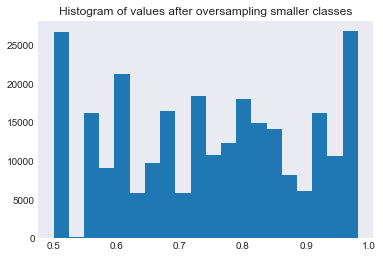

In [14]:
_ = plt.hist(y, 20)
plt.title("Histogram of values after oversampling smaller classes")

## Model fitting

In [15]:
model_factory = [("simple_lr", lambda: linear_model.LinearRegression()),
                 ("mlp_single_layer_10", lambda: MLPRegressor(hidden_layer_sizes=(10,), activation="logistic", alpha=0.001, early_stopping=True)),
                 ("mlp_single_layer_20", lambda: MLPRegressor(hidden_layer_sizes=(20,), activation="logistic", alpha=0.001, early_stopping=True)),
                 ("mlp_single_layer_30", lambda: MLPRegressor(hidden_layer_sizes=(30,), activation="logistic", alpha=0.001, early_stopping=True)),
                 ("mlp_two_layer_10_10", lambda: MLPRegressor(hidden_layer_sizes=(10, 10), activation="logistic", alpha=0.001, early_stopping=True)),
                 ("mlp_two_layer_20_20", lambda: MLPRegressor(hidden_layer_sizes=(20, 20), activation="logistic", alpha=0.001, early_stopping=True)),
                 ("mlp_two_layer_30_30", lambda: MLPRegressor(hidden_layer_sizes=(30, 30), activation="logistic", alpha=0.001, early_stopping=True)),
                ]

In [16]:
kf = KFold(n_splits=5)
stats_dict = OrderedDict()
models_dict = OrderedDict()
for split_idx, (train, test) in enumerate(kf.split(X)):
    train_X = X[train]
    train_y = y[train]
    test_X = X[test]
    test_y = y[test]
    
    models_dict[split_idx] = {}
    print("Fitting split {}".format(split_idx))
    for name, model_builder in model_factory:
        print("\tFitting model: {}".format(name))
        stats_df = stats_dict.get(name, pd.DataFrame())
        reg = model_builder()
        reg.fit(train_X, train_y)
        pred_y = reg.predict(test_X)
        
        models_dict[split_idx][name] = reg
        stats_df = stats_df.append(pd.DataFrame(
            [{"mse": mean_squared_error(test_y, pred_y),
              "mae": mean_absolute_error(test_y, pred_y),
              "r2": r2_score(test_y, pred_y)
             }]), ignore_index=True)
        stats_dict[name] = stats_df

names, stats = zip(*stats_dict.items())
stats_df = pd.concat(stats, keys=names, axis=1)

Fitting split 0
	Fitting model: simple_lr
	Fitting model: mlp_single_layer_10


/Users/peterzvirinsky/Envs/GraphSlices/lib/python2.7/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


	Fitting model: mlp_single_layer_20
	Fitting model: mlp_single_layer_30
	Fitting model: mlp_two_layer_10_10
	Fitting model: mlp_two_layer_20_20
	Fitting model: mlp_two_layer_30_30
Fitting split 1
	Fitting model: simple_lr
	Fitting model: mlp_single_layer_10
	Fitting model: mlp_single_layer_20
	Fitting model: mlp_single_layer_30
	Fitting model: mlp_two_layer_10_10
	Fitting model: mlp_two_layer_20_20
	Fitting model: mlp_two_layer_30_30
Fitting split 2
	Fitting model: simple_lr
	Fitting model: mlp_single_layer_10
	Fitting model: mlp_single_layer_20
	Fitting model: mlp_single_layer_30
	Fitting model: mlp_two_layer_10_10
	Fitting model: mlp_two_layer_20_20
	Fitting model: mlp_two_layer_30_30
Fitting split 3
	Fitting model: simple_lr
	Fitting model: mlp_single_layer_10
	Fitting model: mlp_single_layer_20
	Fitting model: mlp_single_layer_30
	Fitting model: mlp_two_layer_10_10
	Fitting model: mlp_two_layer_20_20
	Fitting model: mlp_two_layer_30_30
Fitting split 4
	Fitting model: simple_lr
	Fit

## Evaluation

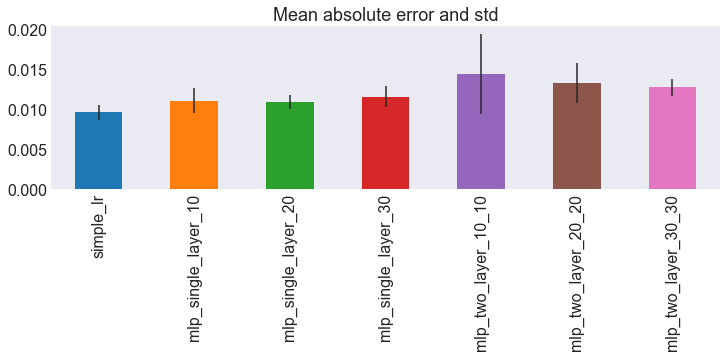

In [17]:
ax = stats_df.mean(axis=0)[:, "mae"].plot(kind="bar", yerr=stats_df.std(axis=0)[:, "mae"], figsize=(12,3), fontsize=16)
ax.set_title("Mean absolute error and std", fontsize=18);

In [18]:
stats_df.mean(axis=0).to_frame(name="mean").merge(
    stats_df.std(axis=0).to_frame("std"), left_index=True, right_index=True
)

mean       std
simple_lr           mae  0.009576  0.000967
                    mse  0.000168  0.000057
                    r2   0.795996  0.098560
mlp_single_layer_10 mae  0.011043  0.001524
                    mse  0.000203  0.000077
                    r2   0.754973  0.110128
mlp_single_layer_20 mae  0.010878  0.000837
                    mse  0.000198  0.000063
                    r2   0.765818  0.091078
mlp_single_layer_30 mae  0.011542  0.001333
                    mse  0.000212  0.000058
                    r2   0.747914  0.100938
mlp_two_layer_10_10 mae  0.014344  0.005007
                    mse  0.000317  0.000168
                    r2   0.666654  0.076039
mlp_two_layer_20_20 mae  0.013222  0.002479
                    mse  0.000262  0.000060
                    r2   0.691692  0.124893
mlp_two_layer_30_30 mae  0.012695  0.001095
                    mse  0.000256  0.000063
                    r2   0.701092  0.097591

# Individual evaluation

In [19]:
test_reg = models_dict[1]["mlp_two_layer_30_30"]

In [20]:
def eval_node(stringId, test_reg):
    test_df = dataset_df[dataset_insdata_df["stringId"] == stringId].copy()
    test_df["year_0_pred"] = test_reg.predict(test_df.drop(["year_0"], axis=1))
    test_df["pred_err"] = (test_df["year_0_pred"] - test_df["year_0"]).abs()
    return test_df

## Creditors

In [21]:
## GE Money Bank
eval_node("gemoneybank", test_reg)

,year_3,year_2,year_1,year_0,year_0_pred,pred_err
2822,0.004590,0.011407,0.016947,0.020687,0.043956,0.023269
2822,0.011407,0.016947,0.020687,0.023165,0.046934,0.023769
2822,0.016947,0.020687,0.023165,0.021894,0.048669,0.026775
2822,0.020687,0.023165,0.021894,0.020265,0.046923,0.026658
2822,0.023165,0.021894,0.020265,0.019640,0.044492,0.024852


In [22]:
## Provident Financial
eval_node("providentfinancial", test_reg)

,year_3,year_2,year_1,year_0,year_0_pred,pred_err
1159,0.000829,0.005893,0.012384,0.016213,0.039430,0.023217
1159,0.005893,0.012384,0.016213,0.019146,0.043081,0.023934
1159,0.012384,0.016213,0.019146,0.021452,0.045047,0.023596
1159,0.016213,0.019146,0.021452,0.022643,0.046891,0.024248
1159,0.019146,0.021452,0.022643,0.022397,0.047747,0.025350


In [23]:
## Cetelem
eval_node(u"cetelemčr", test_reg)

,year_3,year_2,year_1,year_0,year_0_pred,pred_err
5036,0.002239,0.006443,0.009655,0.011391,0.036491,0.025100
5036,0.006443,0.009655,0.011391,0.011027,0.037726,0.026699
5036,0.009655,0.011391,0.011027,0.010179,0.036880,0.026702
5036,0.011391,0.011027,0.010179,0.009462,0.035561,0.026099
5036,0.011027,0.010179,0.009462,0.009030,0.034799,0.025769


## Administrators

In [24]:
eval_node(u"adm_5727", test_reg)

,year_3,year_2,year_1,year_0,year_0_pred,pred_err
19,0.000175,0.000158,0.000141,0.000128,0.026566,0.026438
19,0.000158,0.000141,0.000128,0.000131,0.026554,0.026424
19,0.000141,0.000128,0.000131,0.000123,0.026559,0.026436
19,0.000128,0.000131,0.000123,0.000118,0.026556,0.026437
19,0.000131,0.000123,0.000118,0.000121,0.026549,0.026428


## Debtors

In [25]:
eval_node(u"ksbrins3336/2013", test_reg)

,year_3,year_2,year_1,year_0,year_0_pred,pred_err
5447,0.000175,0.000158,0.000141,0.000128,0.026566,0.026438
5447,0.000158,0.000141,0.000128,0.000118,0.026554,0.026436
5447,0.000141,0.000128,0.000118,0.000111,0.026547,0.026436
5447,0.000128,0.000118,0.000111,0.000107,0.026542,0.026435
5447,0.000118,0.000111,0.000107,0.000109,0.026539,0.026430
